In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.nn import knn_graph, GCNConv, global_mean_pool
from torch_geometric.transforms import NormalizeScale
from tqdm import tqdm
import matplotlib.pyplot as plt
def load_off(file):
    with open(file, 'r') as f:
        lines = f.readlines()
        if lines[0].strip() == 'OFF':
            lines = lines[1:]
        n_verts, n_faces, _ = map(int, lines[0].strip().split())
        vertices = np.array([list(map(float, lines[i + 1].strip().split())) for i in range(n_verts)])
        return vertices


In [4]:
# Custom dataset class for ModelNet10
class ModelNet10Dataset(Dataset):
    def __init__(self, root_dir, split='train', num_points=1024):
        self.root_dir = root_dir
        self.split = split
        self.num_points = num_points
        self.classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.files = []
        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls, split)
            for file_name in os.listdir(cls_dir):
                if file_name.endswith('.off'):
                    self.files.append((os.path.join(cls_dir, file_name), self.class_to_idx[cls]))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path, label = self.files[idx]
        point_cloud = load_off(file_path)
        if len(point_cloud) > self.num_points:
            point_cloud = point_cloud[np.random.choice(len(point_cloud), self.num_points, replace=False)]
        else:
            point_cloud = point_cloud[np.random.choice(len(point_cloud), self.num_points, replace=True)]
        return torch.tensor(point_cloud, dtype=torch.float), torch.tensor(label, dtype=torch.long)


NameError: name 'Dataset' is not defined

In [3]:
# Define data paths
root_dir = 'C:/Users/Owner/Downloads/ModelNet10/ModelNet10'
train_dataset = ModelNet10Dataset(root_dir, split='train')
test_dataset = ModelNet10Dataset(root_dir, split='test')

NameError: name 'ModelNet10Dataset' is not defined

In [11]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class PointNet(nn.Module):
    def __init__(self, num_classes):
        super(PointNet, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(p=0.3)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool1d(x, x.size(-1))
        x = x.view(-1, 1024)
        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)


In [15]:
import torch.optim as optim
from tqdm import tqdm
# Define model, loss function, and optimizer
num_classes = len(train_dataset.classes)
model = PointNet(num_classes).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with progress bar and data tracking
num_epochs = 20
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch")
    for data in train_bar:
        points, labels = data
        points = points.transpose(2, 1).cuda()
        labels = labels.cuda()

        optimizer.zero_grad()
        outputs = model(points)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        train_bar.set_postfix(loss=running_loss / (total / 32), accuracy=100. * correct / total)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100. * correct / total)


Epoch 20/20: 100%|█████████████████████████████████████| 125/125 [02:03<00:00,  1.01batch/s, accuracy=83.4, loss=0.496]


In [16]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        points, labels = data
        points = points.transpose(2, 1).cuda()
        labels = labels.cuda()
        outputs = model(points)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the model on the test set: {100 * correct / total:.2f}%")


Accuracy of the model on the test set: 17.62%


In [1]:
import torch
print(torch.cuda.is_available())


True


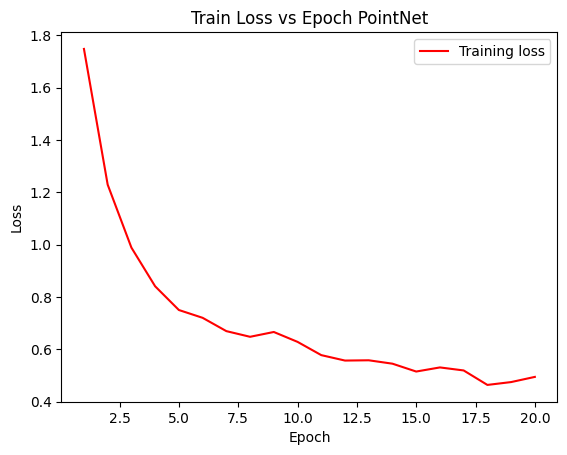

In [27]:
# Plot accuracy and loss vs epoch
import matplotlib.pyplot as plt
# Plot accuracy and loss vs epoch
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, 'r', label='Training loss')
plt.title('Train Loss vs Epoch PointNet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


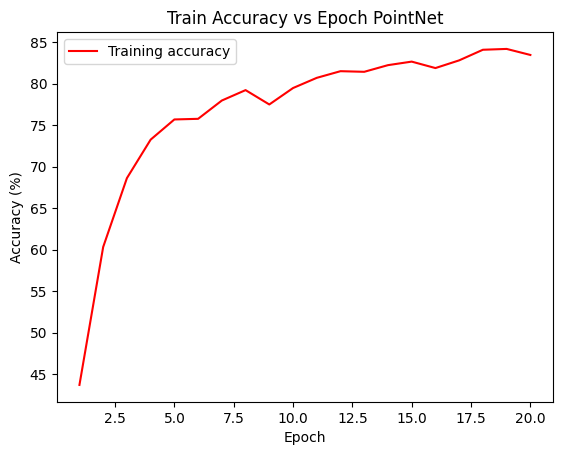

In [28]:
plt.figure()
plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')
plt.title('Train Accuracy vs Epoch PointNet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()